## Globular Cluster Model 

Model for the formation and evolution of globular cluster systems. Current version is published in [Choksi & Gnedin 2019, MNRAS, 486, 331](https://ui.adsabs.harvard.edu/abs/2019MNRAS.486..331C/abstract).

This notebook provides examples of reading the cluster catalog and making plots for Globular Cluster System mass - Host Galaxy mass relation and Age-Metallicity Relation for galaxies of different stellar mass.

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["legend.frameon"] = False
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Verdana']
rcParams['lines.linewidth'] = 1.5
rcParams['xtick.major.size'] = 6
rcParams['ytick.major.size'] = 6
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['legend.fontsize'] = 14
rcParams['text.usetex'] = True
rcParams['savefig.dpi'] = 160
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

### Load the model catalog

Columns:
1. **haloID** - ID of host halo in the Illustris Dark-1 catalog
2. **logMh(z=0)** - virial mass of host galaxy at z=0
3. **logMs(z=0)** - stellar mass of host galaxy at z=0
4. **logMh(zform)** - virial mass of host galaxy at time of cluster formation
5. **logMs(zform)** - stellar mass of host galaxy at time of cluster formation
6. **logM(z=0)** - mass of star cluster at z=0
7. **logM(zform)** - mass of star cluster at time of formation
8. **zform** - redshift of cluster formation
9. **feh** - metallicity [Fe/H] of star cluster
10. **isMPB** - flag for star clusters formed in the main progenitor branch of halo catalog ("in-situ")
11. **haloID@formation** - ID of host halo at time of cluster formation

In [2]:
f = 'z0_cat_mc7.0_8.8_0.58.txt'

hid, logmh, logms, logm, zform, feh = np.loadtxt(f, usecols=(0,1,2,5,7,8), unpack=True)

print("Number of galaxies = %d  Number of clusters = %d" % (len(np.unique(hid)), len(hid)))

Number of galaxies = 248  Number of clusters = 569353


### Globular Cluster System mass - Host Galaxy mass relation

In [3]:
#add end points to binned data by linearly interpolating to minx, maxx
def addEnds(x, y, minx, maxx):
    slope_low = (y[1] - y[0])/(x[1] - x[0])
    slope_high = (y[-1] - y[-2])/(x[-1] - x[-2])
    y_low = y[0] + slope_low*(-x[0] + minx)
    y_high = y[-1] + slope_high*(-x[-1] + maxx)
    y = np.insert(y, 0, y_low)
    y = np.append(y, y_high)
    x = np.insert(x, 0, minx)
    x = np.append(x, maxx)
    return x, y

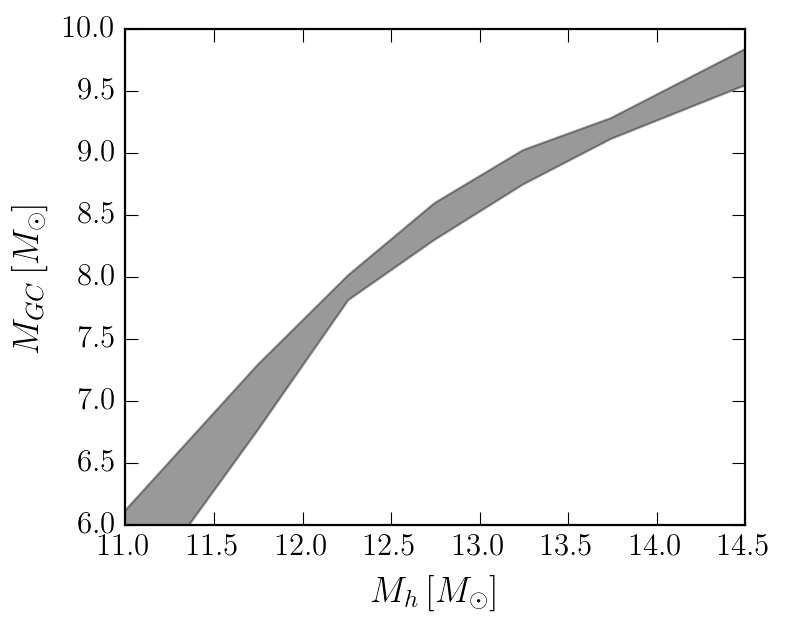

In [4]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)
ax1.set_xlim(11, 14.5)
ax1.set_ylim(6, 10)
ax1.set_xlabel(r'$M_h\,[M_{\odot}]$', fontsize = 16, labelpad = 8)
ax1.set_ylabel(r'$M_{GC}\,[M_{\odot}]$', fontsize = 16)

# calculate Mgc for a given galaxy
mhost, mgc = [], []

for hv in np.unique(hid):
    c = (hid == hv)
    mhost.append(logmh[c][0])
    mgc.append(np.log10(sum(10**logm[c])))

mhost = np.array(mhost)
mgc = np.array(mgc)

# bin Mgc and Mhost
logmh1, p25, p75 = [], [], []
bins = np.arange(11, 15, 0.5)

for i in range(len(bins)-1):
    c = (mhost >= bins[i]) & (mhost < bins[i+1])
    logmh1.append(np.average(mhost[c]))
    p25.append(np.percentile(mgc[c], 25))
    p75.append(np.percentile(mgc[c], 75))

logmh2, p25 = addEnds(logmh1, p25, np.amin(mhost), np.amax(mhost))
logmh2, p75 = addEnds(logmh1, p75, np.amin(mhost), np.amax(mhost))

ax1.fill_between(logmh2, p25, p75, alpha=0.4, color='k')
    
plt.show()

### Age-Metallicity Relation for galaxies of different stellar mass

Convert redshift of formation to cluster age in Gyr

In [5]:
def cosmicTime( z ):
    # WMAP-9 cosmology, as adopted in Illustris Dark-1
    H0 = 7.195e-2 # in Gyr^-1
    omega_matter = 0.2726
    omega_lambda = 1. - omega_matter
    f = omega_matter/(1.-omega_matter)*(1.+z)**3
    t = 2./3./np.sqrt(1.-omega_matter)*np.log((1.+np.sqrt(1.+f))/np.sqrt(f))
    return t/H0

age = cosmicTime(0) - cosmicTime(zform)

In [6]:
from scipy.stats import kde

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def percentage_contours( x, y, levels, col, ls='solid', lw=1 ):
    # density of points
    k = kde.gaussian_kde(np.row_stack((x,y)))
    nbins = 150
    xi, yi = np.mgrid[-3:0.5:nbins*1j, 6:14:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    # percentage contours
    ziSorted = np.sort(zi)
    fracs = np.cumsum( ziSorted[::-1] )[::-1] / np.sum(zi)
    ziLevels = np.zeros(len(levels))
    for i,l in enumerate(levels):
        idx, value = find_nearest(fracs, l)
        ziLevels[i] = ziSorted[idx]
    ax1.contourf(xi, yi, zi.reshape(xi.shape), levels=ziLevels, colors=[col], linestyles=ls, alpha=0.2)

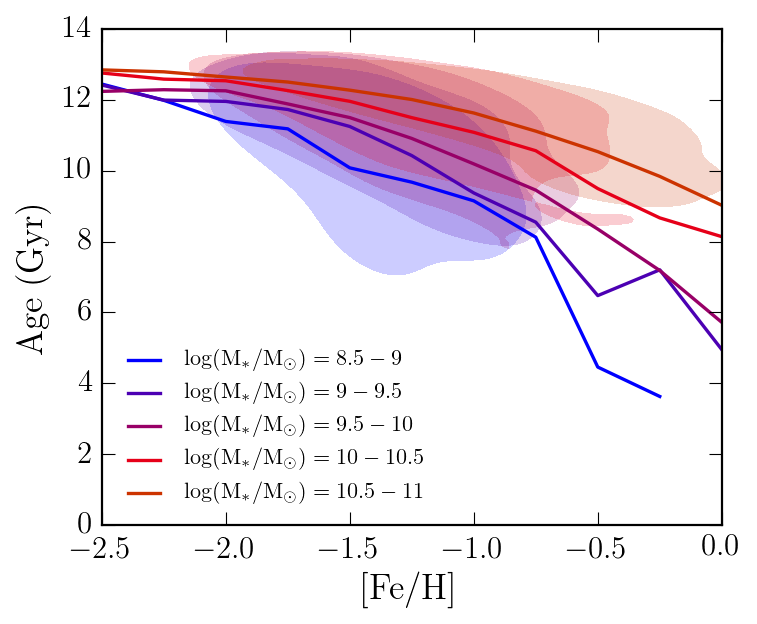

In [8]:
fig = plt.figure(figsize=(5,4))
ax1 = fig.add_subplot(111)
ax1.set_xticks([-2.5,-2,-1.5,-1,-0.5,0])
ax1.set_xlim(-2.5,0)
ax1.set_ylim(0,14)
ax1.set_xlabel(r'$\rm [Fe/H]$', fontsize=16)
ax1.set_ylabel(r'$\rm Age\;(Gyr)$', fontsize=16)

mlist = np.arange(8.5, 10.6, 0.5)
colors = cm.brg(np.linspace(0, 0.6, len(mlist)))
levels = [ 0.7, 0 ]

for m, cols in zip(mlist,colors):
    c = (logms >= m) & (logms < m+0.5) & (logm > 4)
    feh2, age2 = feh[c], age[c]
    percentage_contours(feh2, age2, levels, cols, ls='dotted', lw=0.5)
    # calculate mean relation
    bins = np.arange(-2.5, 0.3, 0.25)
    y = [ np.average(age2[(x-0.125 <= feh2) & (feh2 < x+0.125)]) for x in bins ]
    l = r'$\mathrm{log(M_*/M_\odot)=%g-%g}$'%(m,m+0.5)
    ax1.plot(bins, y, color=cols, label=l)
    
plt.legend(loc='lower left', fontsize=10)
plt.show()